In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Exploración

Distribución de diabetes:


<ipython-input-134-388a6a0e7847>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['Diabetes_binary'], palette='coolwarm')


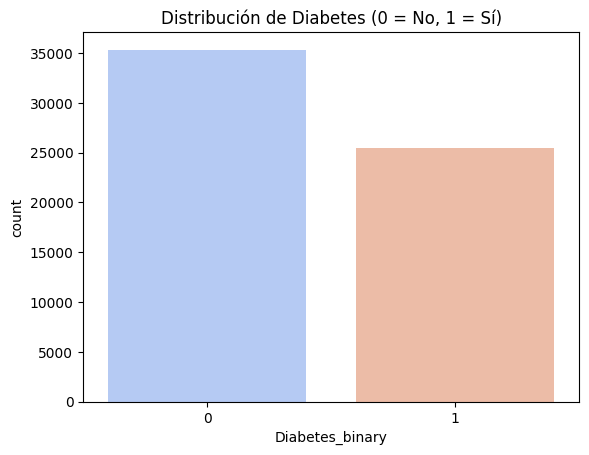

Histogramas de variables numéricas:


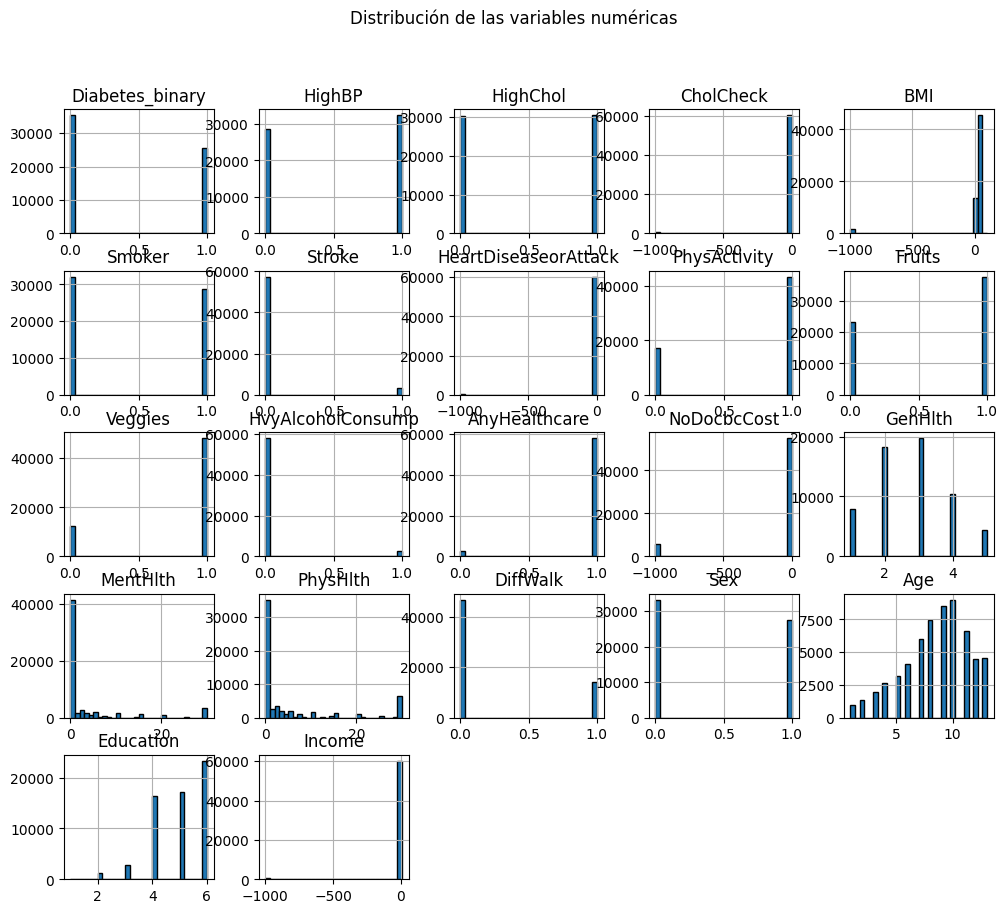

Matriz de correlación:


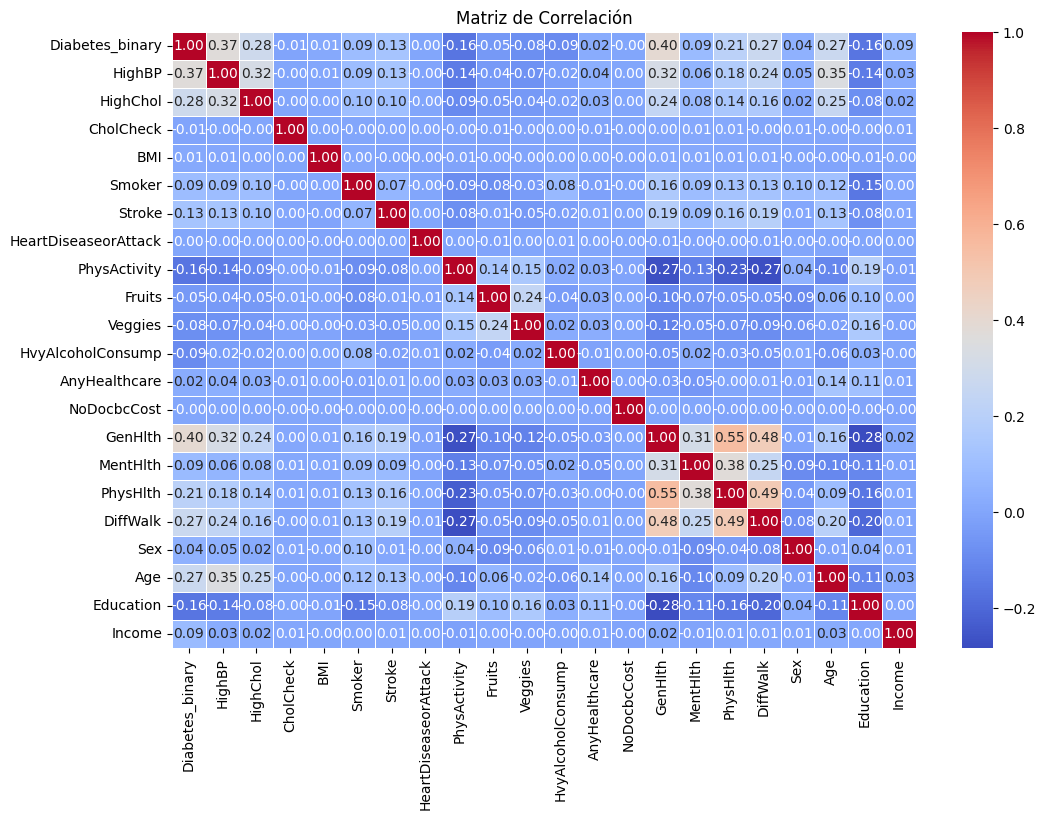

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# Cargar el dataset
df = pd.read_csv('/content/drive/MyDrive/MÁSTER/SIGE/Prácticas/Práctica 1/diabetes.csv', sep=';')

# Distribución de diabetes
print("Distribución de diabetes:")
sns.countplot(x=df['Diabetes_binary'], palette='coolwarm')
plt.title('Distribución de Diabetes (0 = No, 1 = Sí)')
plt.show()

# Histogramas de variables numéricas
print("Histogramas de variables numéricas:")
df.hist(figsize=(12, 10), bins=30, edgecolor='black')
plt.suptitle('Distribución de las variables numéricas')
plt.show()

# Matriz de correlación
print("Matriz de correlación:")
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

# Preprocesamiento

In [ ]:
# Limpieza de valores perdidos (-999)
df.replace(-999, np.nan, inplace=True)

# Imputación de valores faltantes en columnas numéricas
imputer = SimpleImputer(strategy='mean')
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

In [ ]:
# Selección de características más importantes
X = df.drop(columns=['Diabetes_binary'])
y = df['Diabetes_binary'].astype(int)

selector = SelectKBest(score_func=f_classif, k=10)
X_new = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
print("Variables seleccionadas:", selected_features)

Variables seleccionadas: Index(['HighBP', 'HighChol', 'BMI', 'HeartDiseaseorAttack', 'GenHlth',
       'PhysHlth', 'DiffWalk', 'Age', 'Education', 'Income'],
      dtype='object')


In [ ]:
# Identificación y tratamiento de outliers
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

df = remove_outliers(df, numeric_cols)

    Diabetes_binary  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
4               0.0     0.0       0.0        1.0  29.0     1.0     0.0   
7               0.0     0.0       0.0        1.0  31.0     1.0     0.0   
8               0.0     0.0       0.0        1.0  32.0     0.0     0.0   
11              0.0     0.0       0.0        1.0  21.0     0.0     0.0   
12              0.0     1.0       1.0        1.0  27.0     0.0     0.0   

    HeartDiseaseorAttack  PhysActivity  Fruits  ...  AnyHealthcare  \
4                    0.0           1.0     1.0  ...            1.0   
7                    0.0           0.0     1.0  ...            1.0   
8                    0.0           1.0     1.0  ...            1.0   
11                   0.0           1.0     1.0  ...            1.0   
12                   0.0           1.0     1.0  ...            1.0   

    NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  Sex  Age  \
4           0.0      2.0       0.0       0.0       0.0  0.0  8.0  

<ipython-input-138-d3c3e85a1315>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Education_group', data=df, palette='Blues', order=['Baja', 'Media', 'Alta'])
<ipython-input-138-d3c3e85a1315>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Income_group', data=df, palette='Greens', order=['Bajo', 'Medio', 'Alto'])


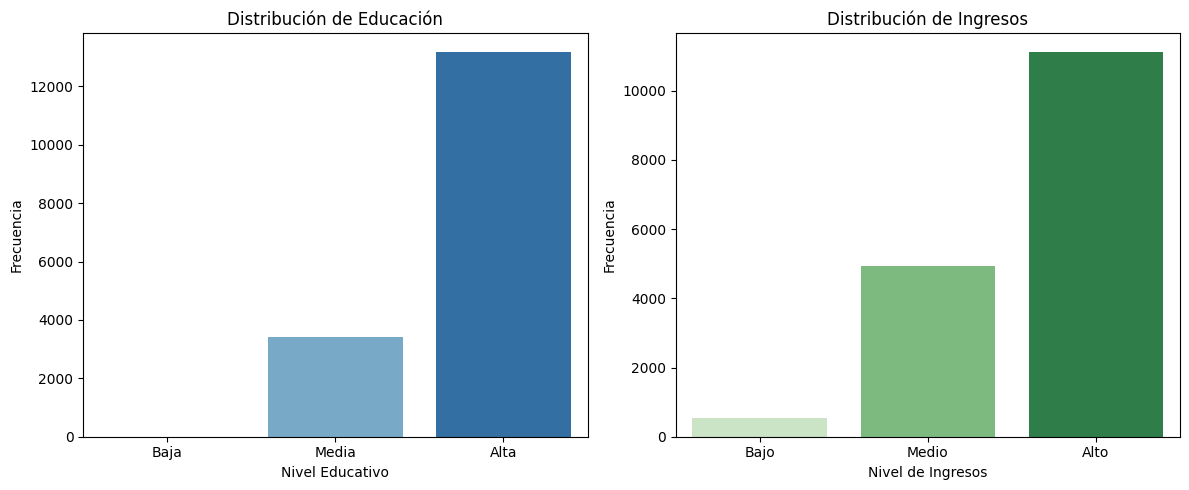

In [ ]:
# Discretización
if 'Income' in df.columns and 'Education' in df.columns:
    df['Income_group'] = pd.cut(df['Income'], bins=[0, 3, 6, 9], labels=['Bajo', 'Medio', 'Alto'], include_lowest=True)
    df['Education_group'] = pd.cut(df['Education'], bins=[0, 2, 4, 6], labels=['Baja', 'Media', 'Alta'], include_lowest=True)
    df.drop(columns=['Income', 'Education'], inplace=True)
else:
    print("Las columnas 'Income' o 'Education' no existen en el DataFrame.")

print(df.head())

# Representación gráfica
if 'Education_group' in df.columns and 'Income_group' in df.columns:
    plt.figure(figsize=(12, 5))

    # Gráfico de distribución de Education_group
    plt.subplot(1, 2, 1)
    sns.countplot(x='Education_group', data=df, palette='Blues', order=['Baja', 'Media', 'Alta'])
    plt.title('Distribución de Educación')
    plt.xlabel('Nivel Educativo')
    plt.ylabel('Frecuencia')

    # Gráfico de distribución de Income_group
    plt.subplot(1, 2, 2)
    sns.countplot(x='Income_group', data=df, palette='Greens', order=['Bajo', 'Medio', 'Alto'])
    plt.title('Distribución de Ingresos')
    plt.xlabel('Nivel de Ingresos')
    plt.ylabel('Frecuencia')

    plt.tight_layout()
    plt.show()
else:
    print("Las columnas 'Education_group' o 'Income_group' no existen en el DataFrame.")


In [ ]:
# Normalización
scaler = StandardScaler()
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [ ]:
# Tratamiento de clases desbalanceadas
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_new, y)

# División en datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

print("Datos preparados para el modelo de clasificación.")

Datos preparados para el modelo de clasificación.


# Entrenamiento de modelos

In [ ]:
# 1. Regresión Logística
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
y_prob_log = log_model.predict_proba(X_test)[:, 1]

# 2. Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

# 3. Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
y_prob_gb = gb_model.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Evaluación de modelos

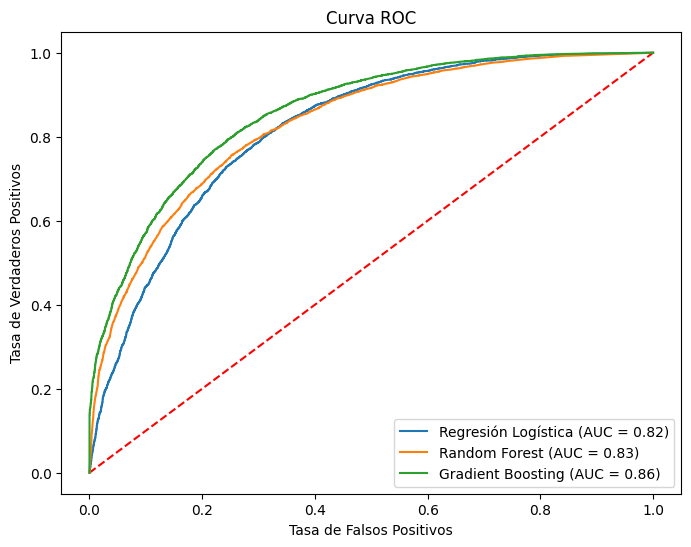


Evaluación de Regresión Logística:
Accuracy: 0.7436169460357875
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.76      0.72      0.74      7090
           1       0.73      0.77      0.75      7049

    accuracy                           0.74     14139
   macro avg       0.74      0.74      0.74     14139
weighted avg       0.74      0.74      0.74     14139


Evaluación de Random Forest:
Accuracy: 0.7507603083669283
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.76      0.73      0.75      7090
           1       0.74      0.77      0.75      7049

    accuracy                           0.75     14139
   macro avg       0.75      0.75      0.75     14139
weighted avg       0.75      0.75      0.75     14139


Evaluación de Gradient Boosting:
Accuracy: 0.7731098380366362
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.79

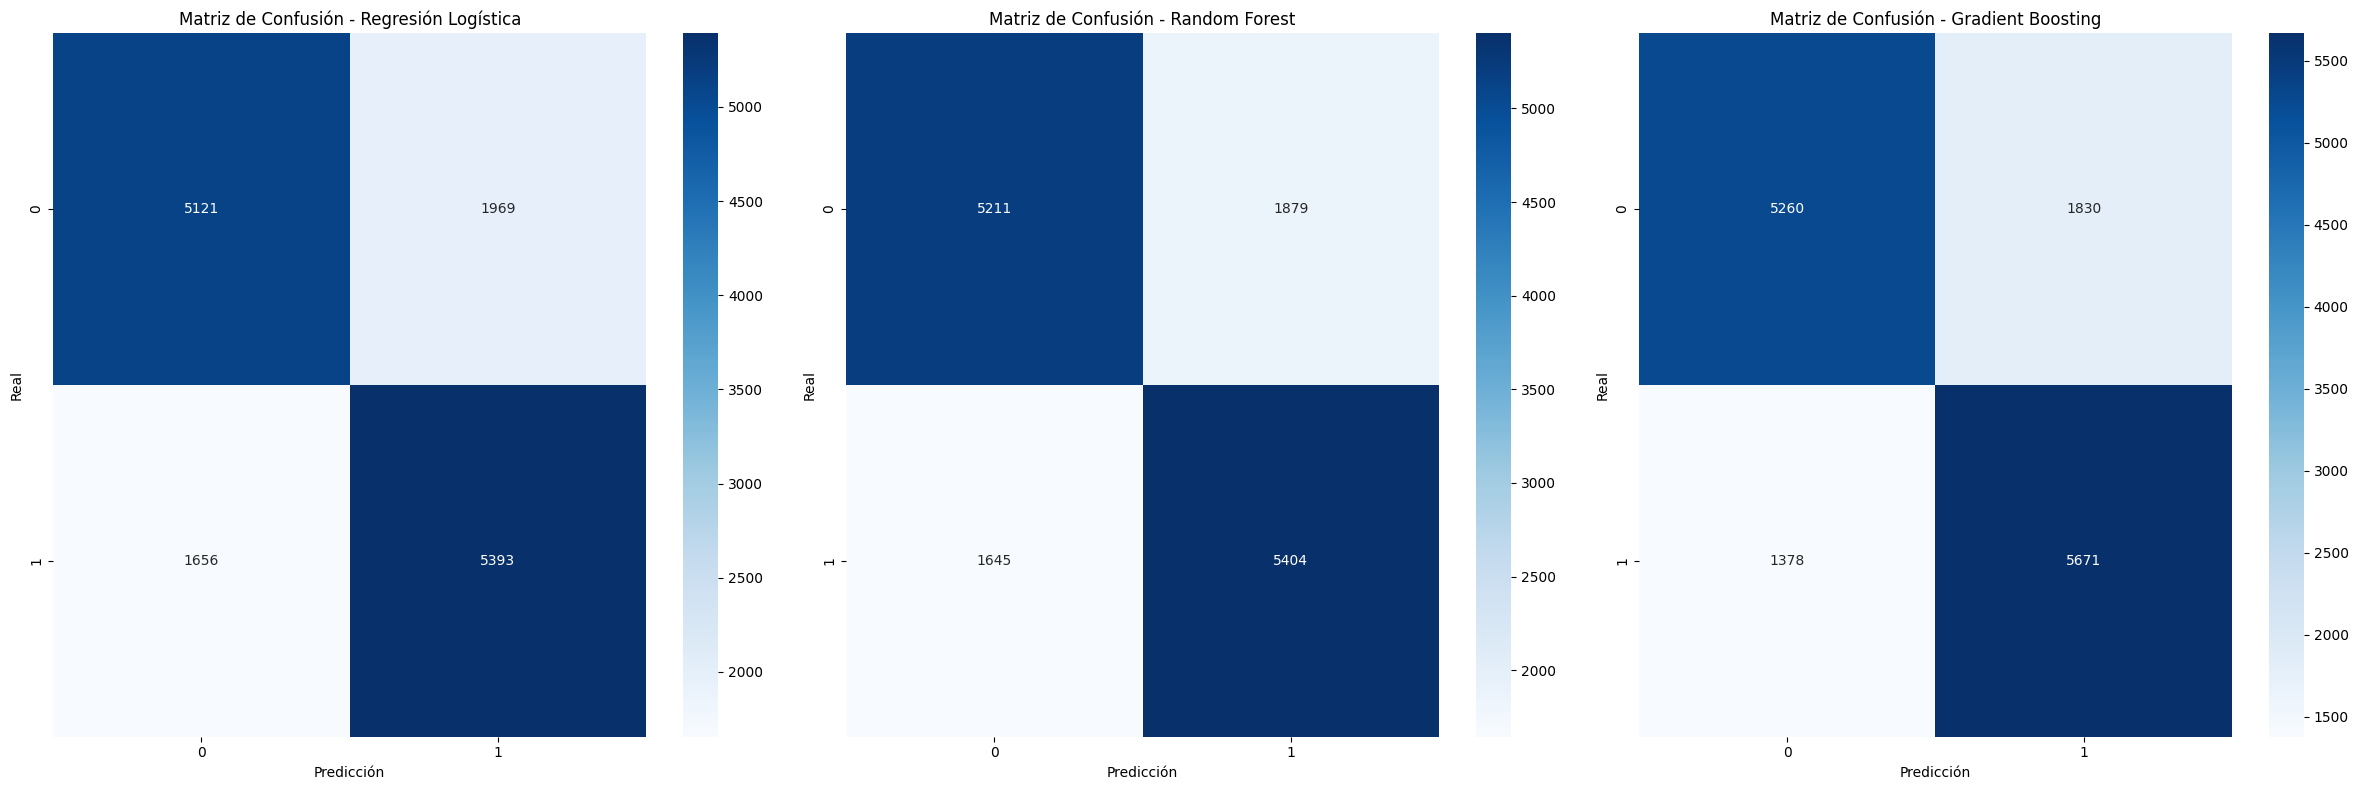

Modelos evaluados correctamente.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

def evaluate_model(y_true, y_pred, y_prob, model_name, ax):
    print(f"\nEvaluación de {model_name}:")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Reporte de Clasificación:\n", classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f"Matriz de Confusión - {model_name}")
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Real")

plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC")

# Evaluar cada modelo y trazar la curva ROC
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
roc_auc_log = auc(fpr_log, tpr_log)
plt.plot(fpr_log, tpr_log, label=f"Regresión Logística (AUC = {roc_auc_log:.2f})")

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.2f})")

fpr_gb, tpr_gb, _ = roc_curve(y_test, y_prob_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)
plt.plot(fpr_gb, tpr_gb, label=f"Gradient Boosting (AUC = {roc_auc_gb:.2f})")

plt.legend()
plt.show()

# Crear subgráficas para las matrices de confusión
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
evaluate_model(y_test, y_pred_log, y_prob_log, "Regresión Logística", axes[0])
evaluate_model(y_test, y_pred_rf, y_prob_rf, "Random Forest", axes[1])
evaluate_model(y_test, y_pred_gb, y_prob_gb, "Gradient Boosting", axes[2])

plt.tight_layout()
plt.show()

print("Modelos evaluados correctamente.")
